In [99]:
#Importing Dependencies
! pip install citipy
import pandas as pd
import matplotlib.pyplot as plt
from citipy import citipy as cp
import openweathermapy.core as owm
import time
import random
import json
import requests
from config import api_key




You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Basic geography to keep in mind: What are geographic coordinate systems?
http://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/about-geographic-coordinate-systems.htm
Latitude and longitude values are traditionally measured either in decimal degrees or in degrees, minutes, and seconds (DMS). Latitude values are measured relative to the equator and range from -90° at the South Pole to +90° at the North Pole. Longitude values are measured relative to the prime meridian. They range from -180° when traveling west to 180° when traveling east. If the prime meridian is at Greenwich, then Australia, which is south of the equator and east of Greenwich, has positive longitude values and negative latitude values.

In [102]:
#Selecting randomly, based on latitude and longitude, at least 500 cities with citipy
#https://stackoverflow.com/questions/19668463/generating-multiple-random-x-y-coordinates-excluding-duplicates

#city = citipy.nearest_city(lat, lng)
#city.city_name     
#city.country_code
#500+ sample coordinates (lat, long)

coordinates = set()

for x in range(-90,90):
    for y in range(-180,180):
        coordinates.add((x,y))

#This code created a dictionary of all possible sets of latitudes - ranging from -90 to 90 - and longitudes - ranging from -180 to 180
#This will be my added to my cities list and later on I will randomly select a sample of these cities.
#print(coordinates)

cities = []

for coordinates_pair in coordinates:
    x,y = coordinates_pair
    cities.append(cp.nearest_city(x,y))

#just checking the .city_name and .country_code functions
print(cities[499].city_name)
print(cities[499].country_code)


roma
au


In [105]:
#https://stackoverflow.com/questions/22412258/get-the-first-element-of-each-tuple-in-a-list-in-python

# I will need this info for my dataframe 

lat = [x[0] for x in coordinates]
lng = [y[1] for y in coordinates]



In [106]:
#curious to know the number of cities from my "cities". 
print(len(cities))



64800


In [107]:
cities[0]

In [108]:
#Citipy returns a citipy object (see abobe in 104) that does not let us promtply identify the information of the city in question
# I need an eventudal dataframe for easy visualization of each city's information. A *for loop* will help out then I can append
#each city name and respective couunty, latitude and longitude to their respective lists and then, create a dataframe
#from my city dictionary.

city_name = []
country = []

for city in cities:
    city_name.append(city.city_name)
    country.append(city.country_code)

city_dict = {
    "city": city_name,
    "country": country,
    "latitude":lat,
    "longitude":lng
}

city_df = pd.DataFrame(city_dict)
city_df.head()


    
    

,city,country,latitude,longitude
0,saint-philippe,re,-35,61
1,saint george,bm,35,-61
2,lavrentiya,ru,72,-169
3,esperance,au,-49,126
4,port hardy,ca,49,-128


In [109]:
#I want a sample of *at least* 500 cities. My DF has 64800 cities. I understand some different 
#countries may have cities with the same name, but (of course) different latitude and longitude. 
#However, for this exercise, I chose to keep cities with unique names to narrow down my DF. 
#Then, I will get a random sample of 1000 and drop cities with non populated information. 
#Finally, I will perform an API call based on (all unique) city names.

city_unique_df = city_df.drop_duplicates(subset="city", keep='first')
city_unique_df.head()
len(city_unique_df)




7957

In [110]:
#Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
city_sample_df = city_unique_df.sample(n=1000, frac=None, replace=False, weights=None, random_state=None, axis=None)
city_sample_df.head()


,city,country,latitude,longitude
7613,tulungagung,id,-8,112
49366,lakhimpur,in,27,94
55164,turinsk,ru,58,64
896,singarayakonda,in,15,81
25931,qurayyat,om,24,60


In [112]:
#Don't forget to reindex your sample table, so the index column will be in order again
city_sample_reindex = city_sample_df.reset_index(drop=True)

city_sample_reindex.head()



,city,country,latitude,longitude
0,tulungagung,id,-8,112
1,lakhimpur,in,27,94
2,turinsk,ru,58,64
3,singarayakonda,in,15,81
4,qurayyat,om,24,60


In [13]:
#* Perform a weather check on each of the cities using a series of successive API calls. 
#* Include a print log of each city as it's being processed with the city number, city name, and requested URL.
#* Save both a CSV of all data retrieved and png images for each scatter plot.

In [113]:
#grab temp for each city in city_sample_reindex
#API call:
#api.openweathermap.org/data/2.5/weather?q={city name}


# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"
count = 0

# Build partial query URL
query_url = f"{url}appid={api_key}&units={units}&q="

city_sample_reindex['temperature'] = ""
city_sample_reindex['humidity'] = ""
city_sample_reindex['cloudiness'] = ""
city_sample_reindex["wind_speed"] = ""


for index,row in city_sample_reindex.iterrows():
    city = row['city']
    final_url = query_url + city.replace(" ", "+")
    #.replace will concatenate the multi space between a city name, for example, sao geraldo do araguaia. Otherwise, the url 
    #would break.
    
    weather_response = requests.get(final_url).json()

    try:
        city_sample_reindex.set_value(index, "temperature", weather_response['main']['temp'])
        city_sample_reindex.set_value(index, "humidity", weather_response['main']['humidity'])
        city_sample_reindex.set_value(index, "cloudiness", weather_response['clouds']['all'])
        city_sample_reindex.set_value(index, "wind_speed", weather_response['wind']['speed'])
      
    
    except:
        
        print(f"No data for this city: {row['city']}")
    
    print(f"City Name: {row['city']}" )
    print(f"URL: {final_url}")
        

# After getting errors I verified with try/except if all cities had info populated. I found out that some had not and their 
#url would give a 404 code.
 

C:\Users\Pati_\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pati_\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pati_\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pati_\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


City Name: tulungagung
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=tulungagung
City Name: lakhimpur
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=lakhimpur
City Name: turinsk
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=turinsk
City Name: singarayakonda
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=singarayakonda
No data for this city: qurayyat
City Name: qurayyat
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=qurayyat
City Name: san lorenzo
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=san+lorenzo
City Name: karachev
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=karachev

City Name: sebastian
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=sebastian
No data for this city: longlac
City Name: longlac
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=longlac
City Name: ambo
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=ambo
City Name: motygino
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=motygino
City Name: nova vicosa
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=nova+vicosa
City Name: marawi
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=marawi
No data for this city: subaytilah
City Name: subaytilah
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=sub

City Name: muriti
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=muriti
City Name: lamovita
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=lamovita
City Name: formosa do rio preto
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=formosa+do+rio+preto
City Name: kareli
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kareli
City Name: sturgeon falls
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=sturgeon+falls
City Name: coracora
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=coracora
No data for this city: yei
City Name: yei
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=yei
City Name:

City Name: lujiang
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=lujiang
No data for this city: sentyabrskiy
City Name: sentyabrskiy
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=sentyabrskiy
No data for this city: urfa
City Name: urfa
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=urfa
City Name: selaphum
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=selaphum
City Name: saint pete beach
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=saint+pete+beach
City Name: ha giang
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=ha+giang
City Name: guerrero negro
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0f

City Name: batemans bay
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=batemans+bay
City Name: port macquarie
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=port+macquarie
City Name: masuguru
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=masuguru
City Name: poso
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=poso
City Name: kichmengskiy gorodok
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kichmengskiy+gorodok
City Name: port alfred
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=port+alfred
City Name: caticlan
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=caticlan
City Name: st

No data for this city: disna
City Name: disna
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=disna
City Name: kirkwood
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kirkwood
City Name: liwale
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=liwale
City Name: cambrai
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=cambrai
City Name: port antonio
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=port+antonio
City Name: capreol
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=capreol
City Name: hoyanger
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=hoyanger
City Name: do gonbadan
URL: http

City Name: sikasso
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=sikasso
City Name: aurora
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=aurora
City Name: kashary
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kashary
City Name: streator
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=streator
City Name: sakti
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=sakti
City Name: tanhacu
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=tanhacu
No data for this city: boljarovo
City Name: boljarovo
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=boljarovo
City Name: ponte de sor
URL: http://

City Name: hwange
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=hwange
City Name: koutiala
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=koutiala
City Name: kodinsk
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kodinsk
City Name: bazarnyye mataki
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=bazarnyye+mataki
No data for this city: mooi river
City Name: mooi river
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=mooi+river
City Name: shagonar
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=shagonar
City Name: ferkessedougou
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=ferkessedo

City Name: hami
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=hami
City Name: otavi
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=otavi
City Name: rosetown
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=rosetown
No data for this city: takob
City Name: takob
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=takob
City Name: ziarat
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=ziarat
City Name: wuda
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=wuda
City Name: melo
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=melo
City Name: yichang
URL: http://api.openweathermap.org/data/2.5/wea

City Name: guerande
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=guerande
City Name: namtsy
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=namtsy
City Name: temple
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=temple
City Name: nouna
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=nouna
City Name: salamanca
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=salamanca
City Name: luzino
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=luzino
City Name: luwuk
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=luwuk
City Name: orel
URL: http://api.openweathermap.org/data/2.5/weather?appid=25b

City Name: luangwa
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=luangwa
City Name: doba
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=doba
City Name: pacific grove
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=pacific+grove
City Name: uvat
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=uvat
City Name: vardo
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=vardo
City Name: leirvik
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=leirvik
City Name: cortez
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=cortez
City Name: neman
URL: http://api.openweathermap.org/data/2.5/weather?appid=

City Name: gunnedah
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=gunnedah
City Name: rolla
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=rolla
City Name: wajir
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=wajir
City Name: kouroussa
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kouroussa
City Name: oriximina
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=oriximina
City Name: pala
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=pala
City Name: muhos
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=muhos
City Name: xicotencatl
URL: http://api.openweathermap.org/data/2.5/weather?ap

City Name: lerik
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=lerik
City Name: bicester
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=bicester
City Name: otradnoye
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=otradnoye
City Name: minna
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=minna
City Name: salmo
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=salmo
City Name: nalgonda
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=nalgonda
City Name: buluang
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=buluang
No data for this city: ozgon
City Name: ozgon
URL: http://api.openweather

City Name: chulym
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=chulym
City Name: gofitskoye
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=gofitskoye
City Name: los zacatones
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=los+zacatones
No data for this city: mananara
City Name: mananara
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=mananara
City Name: aripuana
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=aripuana
City Name: palu
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=palu
City Name: bonthe
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=bonthe
City Name: shizuishan
URL

City Name: kruisfontein
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kruisfontein
City Name: suzun
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=suzun
City Name: puksoozero
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=puksoozero
City Name: lomovka
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=lomovka
City Name: cangzhou
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=cangzhou
City Name: petit goave
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=petit+goave
City Name: kagadi
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kagadi
City Name: ziro
URL: http://api.openweathermap.or

City Name: tayshet
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=tayshet
No data for this city: zabinka
City Name: zabinka
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=zabinka
City Name: catalao
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=catalao
City Name: mpanda
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=mpanda
City Name: moctezuma
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=moctezuma
No data for this city: taburi
City Name: taburi
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=taburi
City Name: ushumun
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=ushumun
City Nam

City Name: fatehpur
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=fatehpur
City Name: kalispell
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=kalispell
No data for this city: litoral del san juan
City Name: litoral del san juan
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=litoral+del+san+juan
City Name: mudgee
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=mudgee
No data for this city: teluk nibung
City Name: teluk nibung
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=teluk+nibung
City Name: yashkul
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a1196e6f153eece0bc0b0fc9eb&units=metric&q=yashkul
City Name: lapua
URL: http://api.openweathermap.org/data/2.5/weather?appid=25bc90a

In [119]:
#I need to find the cities with empty data, fill empty spaces and remove those rows. I chose to fill them with NaN and use .dropna
#function to remove those rows.

city_sample_reindex.head(15)

,city,country,latitude,longitude,temperature,humidity,cloudiness,wind_speed
0,tulungagung,id,-8,112,27.79,91.0,24.0,1.23
1,lakhimpur,in,27,94,20.19,100.0,100.0,1.88
2,turinsk,ru,58,64,-0.92,51.0,88.0,1.78
3,singarayakonda,in,15,81,32.09,52.0,48.0,2.58
4,qurayyat,om,24,60,NaN,NaN,NaN,NaN
5,san lorenzo,ar,-28,-59,28.79,80.0,88.0,2.48
6,karachev,ru,53,35,6.89,61.0,0.0,9.73
7,chimbote,pe,-10,-81,18.14,93.0,0.0,2.08
8,nanchong,cn,31,106,18.99,100.0,92.0,2.23
9,tari,pg,-6,143,25.29,68.0,8.0,3.98


In [120]:
import numpy as np
city_sample_reindex.replace('', np.nan, inplace=True)


In [121]:
city_sample_reindex.head(15)

,city,country,latitude,longitude,temperature,humidity,cloudiness,wind_speed
0,tulungagung,id,-8,112,27.79,91.0,24.0,1.23
1,lakhimpur,in,27,94,20.19,100.0,100.0,1.88
2,turinsk,ru,58,64,-0.92,51.0,88.0,1.78
3,singarayakonda,in,15,81,32.09,52.0,48.0,2.58
4,qurayyat,om,24,60,NaN,NaN,NaN,NaN
5,san lorenzo,ar,-28,-59,28.79,80.0,88.0,2.48
6,karachev,ru,53,35,6.89,61.0,0.0,9.73
7,chimbote,pe,-10,-81,18.14,93.0,0.0,2.08
8,nanchong,cn,31,106,18.99,100.0,92.0,2.23
9,tari,pg,-6,143,25.29,68.0,8.0,3.98


In [122]:
city_sample = city_sample_reindex.dropna()
city_sample.head(15)


,city,country,latitude,longitude,temperature,humidity,cloudiness,wind_speed
0,tulungagung,id,-8,112,27.79,91.0,24.0,1.23
1,lakhimpur,in,27,94,20.19,100.0,100.0,1.88
2,turinsk,ru,58,64,-0.92,51.0,88.0,1.78
3,singarayakonda,in,15,81,32.09,52.0,48.0,2.58
5,san lorenzo,ar,-28,-59,28.79,80.0,88.0,2.48
6,karachev,ru,53,35,6.89,61.0,0.0,9.73
7,chimbote,pe,-10,-81,18.14,93.0,0.0,2.08
8,nanchong,cn,31,106,18.99,100.0,92.0,2.23
9,tari,pg,-6,143,25.29,68.0,8.0,3.98
10,ilinskiy,ru,61,32,3.65,71.0,75.0,11.00


In [123]:
city_sample_final = city_sample.reset_index(drop=True)
city_sample_final.head(15)

,city,country,latitude,longitude,temperature,humidity,cloudiness,wind_speed
0,tulungagung,id,-8,112,27.79,91.0,24.0,1.23
1,lakhimpur,in,27,94,20.19,100.0,100.0,1.88
2,turinsk,ru,58,64,-0.92,51.0,88.0,1.78
3,singarayakonda,in,15,81,32.09,52.0,48.0,2.58
4,san lorenzo,ar,-28,-59,28.79,80.0,88.0,2.48
5,karachev,ru,53,35,6.89,61.0,0.0,9.73
6,chimbote,pe,-10,-81,18.14,93.0,0.0,2.08
7,nanchong,cn,31,106,18.99,100.0,92.0,2.23
8,tari,pg,-6,143,25.29,68.0,8.0,3.98
9,ilinskiy,ru,61,32,3.65,71.0,75.0,11.00


In [125]:
#We ended up with a sample of 919. I'm happy with it!
print(len(city_sample_final))

919


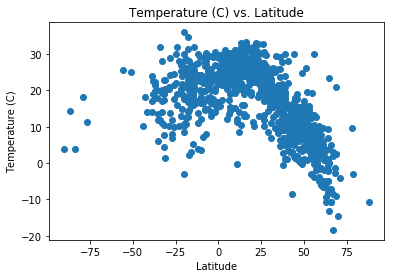

In [126]:
#Build a scatter plot to showcase the relationship:

#* Temperature (F) vs. Latitude

plt.scatter(city_sample_final['latitude'],city_sample_final['temperature'])
plt.title(f"Temperature (C) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Temperature (C)")
plt.savefig("Temperature.png")
plt.show()

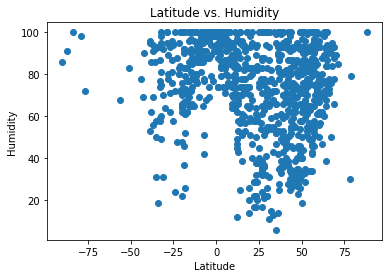

In [127]:
#* Humidity (%) vs. Latitude

plt.scatter(city_sample_final['latitude'],city_sample_final['humidity'])
plt.title(f"Latitude vs. Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.savefig("Humidity.png")
plt.show()

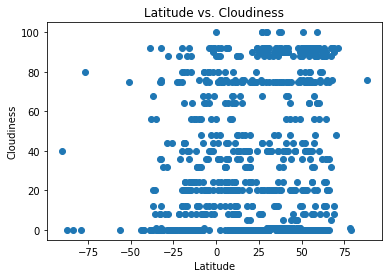

In [128]:
#* Cloudiness (%) vs. Latitude

plt.scatter(city_sample_final['latitude'],city_sample_final['cloudiness'])
plt.title(f"Latitude vs. Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.savefig("Cloudiness.png")
plt.show()

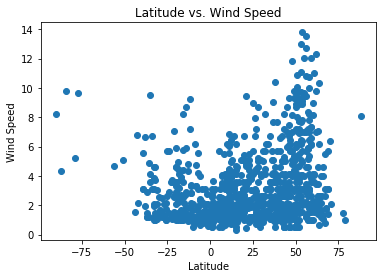

In [129]:
#* Wind Speed (mph) vs. Latitude

plt.scatter(city_sample_final['latitude'],city_sample_final['wind_speed'])
plt.title(f"Latitude vs. Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.savefig("Wind Speed.png")
plt.show()




In [135]:
#DataFrame to CSV
city_sample_final.to_csv("cities_geoinfo.csv", index=False)
df = pd.read_csv("cities_geoinfo.csv")
df.head()

,city,country,latitude,longitude,temperature,humidity,cloudiness,wind_speed
0,tulungagung,id,-8,112,27.79,91.0,24.0,1.23
1,lakhimpur,in,27,94,20.19,100.0,100.0,1.88
2,turinsk,ru,58,64,-0.92,51.0,88.0,1.78
3,singarayakonda,in,15,81,32.09,52.0,48.0,2.58
4,san lorenzo,ar,-28,-59,28.79,80.0,88.0,2.48
